### Equipe: Cássio Medeiros e Rafael Bertoldi Rossi 

In [200]:
from typing import List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from itertools import chain
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from string import punctuation

from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import tqdm

### Load data

In [118]:
base = pd.read_csv('imdb.csv', sep=';')['review,sentiment']

data: List[Tuple[str, str]] = []
    
sentiments = ['positive', 'negative']
    
for text in tqdm.tqdm(base):
    
    words = text.split(',')
    review = ''.join(words[:-1])
    sentiment = words[-1]
    if sentiment in sentiments:
        data.append((review, sentiment))

100%|████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 297893.45it/s]


In [119]:
mapper = {'negative': 0, 'positive': 1}
labels = np.array([mapper[sentiment] for _, sentiment in data])
sentiments = np.array([sentiment for _, sentiment in data])

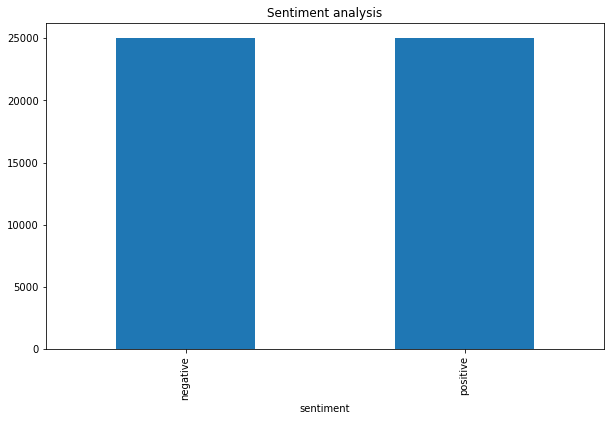

In [120]:
df_label = pd.DataFrame(list(zip(sentiments, labels)), columns=['sentiment', 'label'])

fig, ax = plt.subplots(1, 1)
df_label.groupby('sentiment').size().plot.bar(ax=ax, figsize=(10, 6))

ax.set_title('Sentiment analysis')
plt.show()

### Tokenization

In [96]:
def tokenization(
        data: List[Tuple[str, str]], 
        language: str
    ) -> List[list]:

    other_stopwords = ["1", "Oz", "'ll", "me", "br", "the", '/', '<', '>', 
                       'br','..', '...', '....', 'i', "n't", '.', 'it', 't',
                       "''", "'s", "do"]

    all_stopwords = set(stopwords.words(language) + list(punctuation) + other_stopwords)
    tokenizes: List[list] = []


    for i, (review, _) in tqdm.tqdm(enumerate(data)):

        for punc in punctuation:
            review = review.replace(punc, '')

        text_tokens = word_tokenize(str.lower(review))
        token_without_stopword = [word for word in text_tokens if word not in all_stopwords]
        token_without_stopword = [word for word in token_without_stopword if not str.isnumeric(word)]
        token_without_stopword = [word for word in token_without_stopword if len(word) > 2]
        token_without_stopword = [word for word in token_without_stopword if str.isalpha(word)]


        tokenizes.append((token_without_stopword))
        
    return tokenizes

### Lemmatizer

In [87]:
def lemmatizer(
        data: List[list]
    ) -> List[list]:
    
    lemmatizer = WordNetLemmatizer()

    lemmatizer_list: List[list] = []

    for tokens in tqdm.tqdm(data):

        all_tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
        lemmatizer_list.append(all_tokens)
        
    return lemmatizer_list

### Stemming 

In [102]:
def stemming(
        data: List[list], 
        language: str
    ) -> List[str]:
    
    stemmer = SnowballStemmer(language)
    stemming_list: List[str] = []

    for stemming in tqdm.tqdm(data):
        all_tokens = [stemmer.stem(token) for token in stemming]
        sentence = ' '.join(all_tokens)
        stemming_list.append(sentence)
        
    return stemming_list

### Counting vectorizer

In [98]:
def counting_vectorizer(
        data: List[str]
    ) -> List[str]:
    
    vectorizer = CountVectorizer()
    x_data = vectorizer.fit_transform(data)
    
    return x_data

### Normalizing

In [201]:
def normalizing(data: np.array):
    
    scaler = MaxAbsScaler()
    x_data = scaler.fit_transform(data)
    
    return x_data

### Preprocessing

In [215]:
def preprocessing(
        data: List[Tuple[str, str]], 
        language: str='english'
    ) -> np.array:
    
    tokens = tokenization(data, language)
    lemmatize = lemmatizer(tokens)
    stemmer = stemming(lemmatize, language)
    x_data = counting_vectorizer(stemmer)
    normalize = normalizing(x_data)
    
    return x_data

In [203]:
%%time

x_data = preprocessing(data)

49955it [00:44, 1116.71it/s]
100%|███████████████████████████████████████████████████████████████████████████| 49955/49955 [01:21<00:00, 611.76it/s]


Wall time: 2min 36s


### Train test split

In [245]:
x_train, x_test, y_train, y_test = train_test_split(x_data[:49000], labels[:49000], test_size=0.2)

### Modeling

In [191]:
%%time

grid={
    "C": np.logspace(-3, 3, 5),
    "penalty": ["l1","l2"],
    "solver": ['liblinear']
}

model_cv = LogisticRegression()
model_cv = GridSearchCV(model_cv, grid, cv=5)

model_cv.fit(x_train,y_train)
print(model_cv.best_params_)

Wall time: 1min 9s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [195]:
%%time

model = LogisticRegression(**model_cv.best_params_)
model.fit(x_train, y_train)
yhat = model.predict(x_test)

Wall time: 1.59 s


### Evaluation

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4992
           1       0.89      0.90      0.89      4999

    accuracy                           0.89      9991
   macro avg       0.89      0.89      0.89      9991
weighted avg       0.89      0.89      0.89      9991



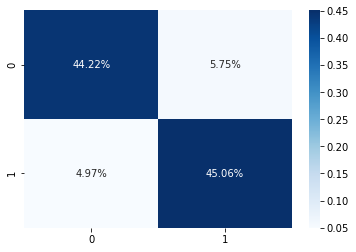

In [196]:
cf_matrix = confusion_matrix(y_test, yhat)
print(classification_report(y_test, yhat))
sns.heatmap(cf_matrix/cf_matrix.sum(), annot=True, fmt='.2%', cmap='Blues')



## Comparing

In [286]:
def predict_sia(data: List[str]):
    
    predictions: int = []
        
    sia = SentimentIntensityAnalyzer()
        
    for text in data:
        
        value = sia.polarity_scores(text)
        value.pop("compound")
        predicted_value = np.argmax([val for val in value.values()])
        predictions.append(1 if predicted_value > 1 else predicted_value)
    
    return predictions

In [287]:
size_validation = len(data) - len(y_train) - len(y_test)
size_validation

955

In [288]:
x_validation_normalize = x_data[-size_validation:]
x_validation_sia = [text for text, _ in data[-size_validation:]]
y_validation = labels[-size_validation:]

#### Logistic Regression

In [289]:
y_hat_model = model.predict(x_validation_normalize)

print(f'Accuracy: {accuracy_score(y_validation, y_hat_model):.2f}')

Accuracy: 0.87


#### Sentiment Intensity Analyzer (NLTK)

In [290]:
y_hat_sia = predict_sia(x_validation_sia)

print(f'Accuracy: {accuracy_score(y_validation, y_hat_sia):.2f}')

Accuracy: 0.49
